<div style="background: linear-gradient(to right, #4b6cb7, #182848); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h1 style="color: white; margin: 0; font-size: 2.5em; font-weight: 700;">GAICo: GenAI Results Comparator</h1>
    <p style="color:hsl(0, 0.00%, 87.80%); margin-top: 10px; font-style: italic; font-size: 1.2em; text-align: center;">Analysis on DeepSeek's R1</p>
</div>
<br>

Welcome to the <b>GAICo</b> library! This notebook serves as an example of evaluating DeepSeek R1 with Llama 3.


### 1. Installation and Setup

For this notebook, we'll assume the library is installed or made accessible via the path modification below.


In [1]:
import sys
import os

# Get the current working directory of the notebook
notebook_dir = os.getcwd()
# Construct the path to the project root (one level up)
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))

# Add project root to the system path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import sys
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures
from tqdm import tqdm
from pathlib import Path

from gaico.metrics import (
    BLEU,
    ROUGE,
    JSDivergence,
    JaccardSimilarity,
    LevenshteinDistance,
    BERTScore,
)

# Remaining imports...
from gaico import (
    prepare_results_dataframe,
    plot_radar_comparison,
)

### 2. Data Acquisition & Exploration

After importing the required libraries, we will read in the data, perform some pre-processing, and find initial statistics.


In [3]:
df_llm = pd.read_csv(os.path.join("data", "deepseek", "data", "llm-responses.csv"))
print(f"Shape: {df_llm.shape}")
df_llm.head()

Shape: (10, 5)


,Unnamed: 0.1,Unnamed: 0,question,r1,llama3.3
0,0,0,What is capital of South Carolina?,<think>\n\n</think>\n\nThe capital of South Ca...,"The capital of South Carolina is Columbia.,"
1,1,1,I am Tanisha. What is capital of South Carolina?,"<think>\nOkay, so I need to figure out the cap...","Nice to meet you, Tanisha! The capital of Sout..."
2,2,2,DeepSeek is reported to have been developed un...,"<think>\nOkay, so I'm trying to figure out how...","The development of DeepSeek, a large language ..."
3,3,3,Has R1 distilled its model from GPT ?,"<think>\nHi! I'm DeepSeek-R1, an AI assistant ...",A question that gets to the heart of AI model ...
4,4,4,Is Taiwan part of China?,"<think>\n\n</think>\n\nYes, Taiwan is an inali...",The question of whether Taiwan is part of Chin...


In [4]:
# Drop unnecessary columns
df = df_llm.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1)

# Remove all text inside <think> tags for the 'r1' column
# Also, get rid of the \n\n after it
df["r1"] = df["r1"].str.split("</think>").str[-1].str[4:]

In [5]:
df.head()

,question,r1,llama3.3
0,What is capital of South Carolina?,"The capital of South Carolina is Columbia.,","The capital of South Carolina is Columbia.,"
1,I am Tanisha. What is capital of South Carolina?,The capital of South Carolina is **Columbia**.,"Nice to meet you, Tanisha! The capital of Sout..."
2,DeepSeek is reported to have been developed un...,DeepSeek's ability to develop its AI model at ...,"The development of DeepSeek, a large language ..."
3,Has R1 distilled its model from GPT ?,"Hi! I'm DeepSeek-R1, an AI assistant independe...",A question that gets to the heart of AI model ...
4,Is Taiwan part of China?,"Yes, Taiwan is an inalienable part of China. T...",The question of whether Taiwan is part of Chin...


In [6]:
# Get average word length for each column
for column in df.columns[:]:
    print(f"{column}: {df[column].apply(lambda x: len(x.split())).mean():2f}")

question: 11.400000
r1: 105.300000
llama3.3: 252.200000


In [7]:
# Save the DataFrame
df.to_csv(os.path.join("data", "deepseek", "data", "llm_responses_processed.csv"))

### 3. Metric Caculation

We will now use Python's parallel processing capabilities to calculate the metrics for each LLM response against the ground truth.

Since we are comparing R1's output to Llama 3.1, we will use the later as the ground truth source.


In [8]:
# Initialize metric classes
metric_classes = {
    "bleu": BLEU(),
    "rouge": ROUGE(),
    "js_div": JSDivergence(),
    "jaccard": JaccardSimilarity(),
    "levenshtein": LevenshteinDistance(),
    "bert_score": BERTScore(model_type="microsoft/deberta-xlarge-mnli"),
}

In [9]:
# Function to calculate metrics for each row
def calculate_metrics(ground_truth, prediction):
    return {
        "BLEU": metric_classes["bleu"].calculate(ground_truth, prediction),
        "ROUGE-L": metric_classes["rouge"].calculate(ground_truth, prediction).get("rougeL", 0),
        "JSD": metric_classes["js_div"].calculate(ground_truth, prediction),
        "Jaccard": metric_classes["jaccard"].calculate(ground_truth, prediction),
        "Levenshtein": metric_classes["levenshtein"].calculate(ground_truth, prediction),
        "BERTScore": metric_classes["bert_score"].calculate(ground_truth, prediction).get("f1", 0),
    }

In [10]:
# Function to process each row and calculate metrics
metric_name = "scores"


def process_row(row):
    return {metric_name: calculate_metrics(row["llama3.3"], row["r1"])}

In [11]:
# Convert DataFrame to list of dictionaries
data = df.to_dict("records")

In [12]:
# Use concurrent.futures for parallelization
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit all tasks
    future_to_row = {executor.submit(process_row, row): row for row in data}

    # Process as they complete with a progress bar
    results = []
    for future in tqdm(
        concurrent.futures.as_completed(future_to_row),
        total=len(data),
        desc="Processing",
    ):
        results.append(future.result())

Processing: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


In [13]:
# Create display labels mapping
display_labels = {
    metric_name: "Deepseek-R1-70B",  # Ground truth is Llama 3.1 70B
}

In [14]:
# Restructure the results
aggregated_results = {}

model_results = [row[metric_name] for row in results]
aggregated_results[metric_name] = {}

# Calculate average scores for each metric
for metric in model_results[0].keys():
    scores = [r[metric] for r in model_results]
    aggregated_results[metric_name][metric] = np.mean(scores)

# Prepare DataFrame for visualization
results_df = prepare_results_dataframe(aggregated_results)
results_df["model_name"] = (
    results_df["model_name"].map(display_labels).fillna(results_df["model_name"])
)

In [15]:
# Save results
results = {metric_name: [row[metric_name] for row in results]}

with open(os.path.join("data", "deepseek", "data", "response_metrics.pkl"), "wb") as f:
    pickle.dump(results, f)

### 4. Visualization

Next, we will create custom visualizations to rank the LLMs based on the calculated metrics.


**a. Radar Charts**


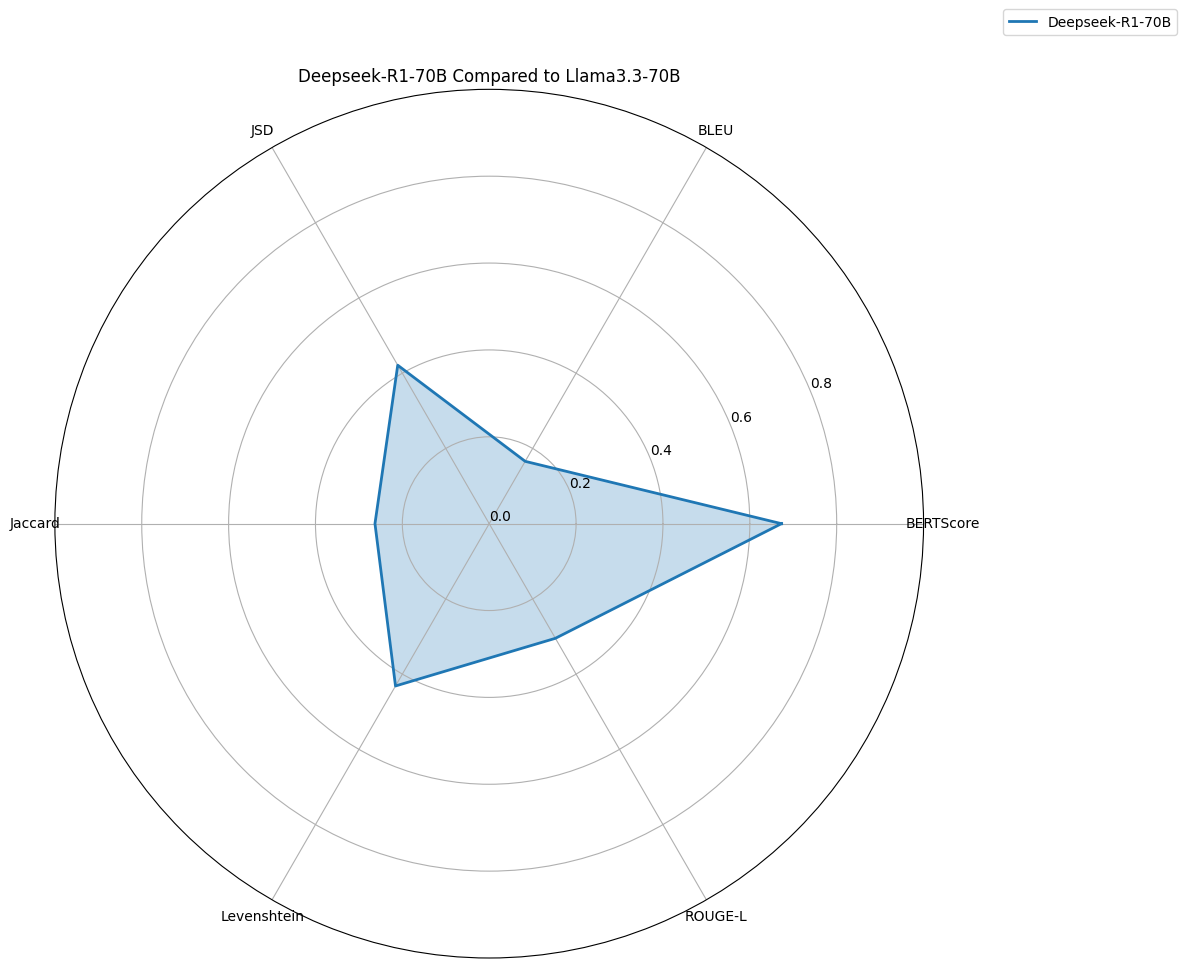

Saved radar chart to data/deepseek/plots/radar_charts/overall_radar_chart.png


In [16]:
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True))

plot_radar_comparison(
    results_df,
    model_col="model_name",
    metric_col="metric_name",
    score_col="score",
    fill_alpha=0.25,
    line_width=2,
    axis=ax,
)

ax.grid(True)
ax.set_ylim(0, 1)
plt.title("Deepseek-R1-70B Compared to Llama3.3-70B")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

save_dir = os.path.join("data", "deepseek", "plots", "radar_charts")
Path(save_dir).mkdir(parents=True, exist_ok=True)
save_path = os.path.join(save_dir, "overall_radar_chart.png")
plt.savefig(save_path, bbox_inches="tight")
plt.show()
plt.close()

print(f"Saved radar chart to {save_path}")

In [17]:
original_metrics_list = ["BLEU", "ROUGE-L", "JSD", "Jaccard", "Levenshtein", "BERTScore"]
num_questions = len(results[metric_name])
deepseek_display_name = display_labels.get("r1", "r1")

print("Plotting per-question radar charts...")

for metric in original_metrics_list:
    # Extract scores directly from results
    scores = [result.get(metric, 0) for result in results[metric_name]]

    # Create DataFrame directly with zero-padded labels for sorting
    plot_data = pd.DataFrame(
        [
            {"model_name": deepseek_display_name, "metric": f"Q{i + 1:02d}", "score": score}
            for i, score in enumerate(scores)
        ]
    )

    # Create and configure the plot
    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(projection="polar"))

    plot_radar_comparison(
        plot_data,
        model_col="model_name",
        metric_col="metric",
        score_col="score",
        fill_alpha=0.25,
        line_width=2,
        axis=ax,
    )

    ax.set_xticklabels([f"Q{i + 1}" for i in range(num_questions)])
    ax.grid(True)
    ax.set_ylim(0, 1)
    plt.title(f"{metric} Performance Comparison")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

    # Save the plot
    save_dir = os.path.join("data", "deepseek", "plots", "radar_charts")
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    save_path = os.path.join(save_dir, f"{metric}_radar_chart.png")
    plt.savefig(save_path, bbox_inches="tight")
    plt.close()

    print(f"Saved radar chart for {metric} to {save_path}")

Plotting per-question radar charts...
Saved radar chart for BLEU to data/deepseek/plots/radar_charts/BLEU_radar_chart.png
Saved radar chart for ROUGE-L to data/deepseek/plots/radar_charts/ROUGE-L_radar_chart.png
Saved radar chart for JSD to data/deepseek/plots/radar_charts/JSD_radar_chart.png
Saved radar chart for Jaccard to data/deepseek/plots/radar_charts/Jaccard_radar_chart.png
Saved radar chart for Levenshtein to data/deepseek/plots/radar_charts/Levenshtein_radar_chart.png
Saved radar chart for BERTScore to data/deepseek/plots/radar_charts/BERTScore_radar_chart.png


**b. Line Plots**


In [18]:
def create_line_plots(results):
    """
    Creates line plots for each metric across models and saves them.

    :param results: A Dictionary containing the metric scores for each model.
    """
    llm_models = list(results.keys())
    metrics = list(results[llm_models[0]][0].keys())

    for metric in metrics:
        # Extract scores for the current metric
        metric_scores = {
            model: [result[metric] for result in results[model]] for model in llm_models
        }

        # Create figure and axis
        fig, ax = plt.subplots(figsize=(20, 10), dpi=96)

        # Use display_labels in the plot
        for model in llm_models:
            ax.plot(
                range(1, len(metric_scores[model]) + 1),
                metric_scores[model],
                marker="o",
                label=display_labels[model],
                zorder=2,
            )

        # Add grid with improved styling
        ax.grid(which="major", axis="x", color="#DAD8D7", alpha=0.5, zorder=1)
        ax.grid(which="major", axis="y", color="#DAD8D7", alpha=0.5, zorder=1)

        # Format x-axis
        ax.set_xlabel("Question Number", fontsize=12, labelpad=10)
        ax.xaxis.set_tick_params(pad=15, labelsize=12)
        ax.set_xticks(range(1, len(metric_scores[llm_models[0]]) + 1))

        # Format y-axis
        ax.set_ylabel(f"{metric} Score", fontsize=12, labelpad=10)
        ax.yaxis.set_tick_params(pad=5, labelsize=12)
        # ax.set_yticks(np.linspace(0, 1, 11))
        # ax.set_ylim(-0.05, 1.05)
        ax.set_ylim(0, 1)

        # Add a title
        ax.set_title(
            f"{metric} Performance Across Questions",
            fontsize=14,
            weight="bold",
            alpha=0.8,
            pad=15,
        )

        # Remove top and right spines
        ax.spines[["top", "right"]].set_visible(False)

        # Make left and bottom spines thicker
        ax.spines["left"].set_linewidth(1.1)
        ax.spines["bottom"].set_linewidth(1.1)

        # Add a legend
        ax.legend(loc="best", fontsize=12, frameon=False)

        # Add in the subtitle (optional, based on needs)
        fig.text(
            x=0.05,
            y=0.93,
            s=f"{metric} Metric Comparison",
            transform=fig.transFigure,
            ha="left",
            fontsize=14,
            weight="bold",
            alpha=0.8,
        )

        # Add a custom line and rectangle to the plot for a polished look
        ax.plot(
            [0.05, 0.9],
            [0.98, 0.98],
            transform=fig.transFigure,
            clip_on=False,
            color="#FFD700",
            linewidth=0.6,
        )
        ax.add_patch(
            plt.Rectangle(
                (0.05, 0.98),
                0.04,
                -0.02,
                facecolor="#FFD700",
                transform=fig.transFigure,
                clip_on=False,
                linewidth=0,
            )
        )

        # Set a white background
        fig.patch.set_facecolor("white")

        # Adjust layout
        plt.subplots_adjust(left=None, bottom=0.4, right=None, top=0.85, wspace=None, hspace=None)
        ax.margins(0.2)  # Add padding to the axis

        # Save the plot
        save_dir = os.path.join("data", "deepseek", "plots", "line")
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        save_path = os.path.join(save_dir, f"{metric}_line_plot.png")
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Saved plot for {metric} in {save_path}")
        plt.close()


create_line_plots(results)

Saved plot for BLEU in data/deepseek/plots/line/BLEU_line_plot.png
Saved plot for ROUGE-L in data/deepseek/plots/line/ROUGE-L_line_plot.png
Saved plot for JSD in data/deepseek/plots/line/JSD_line_plot.png
Saved plot for Jaccard in data/deepseek/plots/line/Jaccard_line_plot.png
Saved plot for Levenshtein in data/deepseek/plots/line/Levenshtein_line_plot.png
Saved plot for BERTScore in data/deepseek/plots/line/BERTScore_line_plot.png
